In [1]:
%matplotlib inline
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable


In [2]:
# 查看准确率
net_to_save_dir = "Saved_Models"
saved_model_name = 'Best_model.t7'
fold=1
enabled_nets = ["ACNN", "AlexNet"]
enabled_datasets = ["JAFFE", "CK+48", "CK+", "FER2013"]
# for net in enabled_nets:
#     for dataset in enabled_datasets:
#         net_to_save_path = os.path.join(net_to_save_dir, dataset + '_' + net + "_" + str(fold))
#         checkpoint = torch.load(os.path.join(net_to_save_path, saved_model_name))
#         best_acc = checkpoint['best_test_acc']
#         best_acc_epoch = checkpoint['best_test_acc_epoch']
#         currect_map = checkpoint['correct_map']
#         print("---------------net: %s, dataset: %s---------------" % (net, dataset))
#         print("best_acc:", best_acc)
#         print("best_acc_epoch:", best_acc_epoch)
#         print("currect_map:", currect_map)

In [6]:
from networks.ACNN import ACNN
from networks.AlexNet import AlexNet
from dal.CKPlus48_DataSet import CKPlus48
from dal.FER2013_DataSet import FER2013
from dal.JAFFE_DataSet import JAFFE
import transforms.transforms as transforms
from utils.utils import draw_img
from PIL import Image
from math import ceil, floor
import torch.nn as nn

In [7]:
# 配置信息
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")
net_name, n_classes = 'ACNN', 7

if net_name == "ACNN":
    net = ACNN(n_classes=n_classes).to(DEVICE)
elif net_name == "AlexNet":
    net = AlexNet(n_classes=n_classes).to(DEVICE)
input_img_size = net.input_size
transform_train = transforms.Compose([
    transforms.Resize(input_img_size),  # 缩放将图片的最小边缩放为 input_img_size，因此如果输入是费正方形的，那么输出也不是正方形的
    transforms.RandomCrop(input_img_size),  # 用于将非正方形的图片进行处理
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_img_size = int(input_img_size * 1.1)  # 测试时，图片resize大小
transform_test = transforms.Compose([
    transforms.Resize(test_img_size),
    transforms.TenCrop(input_img_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])
dataset = 'CK+'
target_type='ls'
if dataset == "JAFFE":
    test_data = JAFFE(is_train=False, transform=transform_test, target_type=target_type)
elif dataset == "CK+48":
    test_data = CKPlus48(is_train=False, transform=transform_test, target_type=target_type)
elif dataset == "CK+":
    test_data = CKPlus48(is_train=False, transform=transform_test, target_type=target_type, img_dir_pre_path="data/CK+")
elif dataset == "FER2013":
    test_data = FER2013(is_train=False, private_test=True, transform=transform_test, target_type=target_type)
else:
    assert("opt.dataset should be in %s, but got %s" % (enabled_datasets, dataset))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

# 获取model
net_to_save_path = os.path.join(net_to_save_dir, dataset + '_' + net_name + "_" + str(fold))
print("get net parameters from:", net_to_save_path)
checkpoint = torch.load(os.path.join(net_to_save_path, saved_model_name))
net.load_state_dict(checkpoint['net'])
print("---------------net: %s, dataset: %s---------------" % (net_name, dataset))

train_num:  906  test_num: 75
get net parameters from: Saved_Models\CK+_ACNN_1
---------------net: ACNN, dataset: CK+---------------


In [8]:
# 获取数据
inputs, targets = next(iter(test_loader))
# print(inputs.shape, targets)
# input = inputs[0][0][0]
# print(input.shape)
# draw_img(input)

bs, ncrops, c, h, w = np.shape(inputs)
inputs = inputs.view(-1, c, h, w)
if use_cuda:
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
inputs, targets = Variable(inputs), Variable(targets)

In [9]:
def draw_features_of_layer(layer_number=-1, blank_size = 2, img_save_dir = "Saved_Virtualizations", img_save_name = "default"):
    '''
    绘制特征层的输出情况，layer_number=-1表示绘制最后一层
    '''
    # 绑定并测试
    features_hook = []
    def get_features_hook(self,input,output):
        features_hook.append(input)

    if layer_number >= 0:
        handler = net.features[layer_number].register_forward_hook(get_features_hook)
    else:
        handler = net.features[-1].register_forward_hook(get_features_hook)
    with torch.no_grad():
        outputs = net(inputs)
    handler.remove()

    # 可视化展示
    images = np.array(features_hook[0][0].cpu())
#     print(images.shape)
    for i in range(len(images)):
        print("-----------img %s layer %s------------" % (str(i), str(layer_number)))
        image = images[i]
#         print("image shape:", image.shape)
        image_shape = image.shape
        col_num = int(ceil(image_shape[0] ** 0.5))
        row_num = int(ceil(image_shape[0] / col_num))
        height =  row_num * image_shape[1]
        width =  col_num * image_shape[2]
#         print(col_num, row_num, height, width)
        img_arr = np.array([[0.5 for _ in range(width+(col_num-1)*blank_size)]for _ in range(height+(row_num-1)*blank_size)])
        for j in range(len(image)):
            start_row_index, start_col_index =  (j//col_num)*(blank_size+image_shape[1]), (j%col_num)*(blank_size+image_shape[2])
            for row_pixel_index in range(image_shape[1]):
                for col_pixel_index in range(image_shape[2]):
                    img_arr[start_row_index+row_pixel_index][start_col_index+col_pixel_index] = image[j][row_pixel_index][col_pixel_index]
        img = Image.fromarray(img_arr)
        if not os.path.exists(img_save_dir):
            os.mkdir(img_save_dir)
        draw_img(img, os.path.join(img_save_dir, img_save_name+"_of_img_"+str(i)))
        break

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 128, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(64, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU(inplace)
  (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
)
-----------img 0 layer 0------------
saved fig to Saved_Virtualizations\feature_layer_0_of_img_0
-----------img 0 layer 1------------
saved fig to Saved_Virtualizations\feature_layer_1_of_img_0
-----------img 0 layer 2------------
saved fig to Saved_Virtualizations\feature_layer_2_of_img_0
-----------img 0 layer 3------------
saved fig to

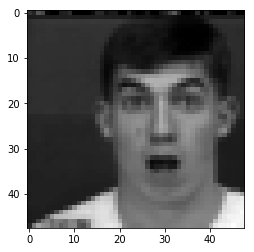

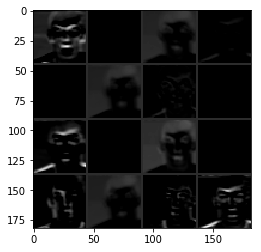

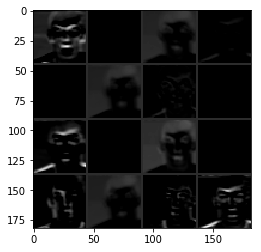

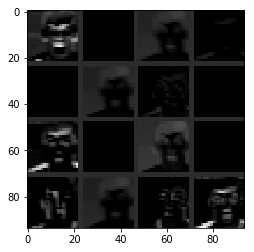

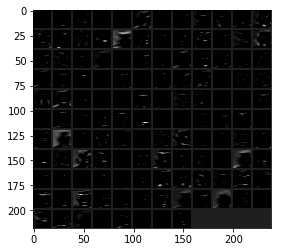

In [10]:
print(net.features)
feature_indexes = [0,3,6,9,-1]
for i in range(len(feature_indexes)):
    idx = feature_indexes[i] 
    draw_features_of_layer(i, img_save_name="feature_layer_"+str(i))
#     print(net.features[idx])

In [11]:
for layer in net.named_modules():
    if isinstance(layer[1],nn.Conv2d):
         print(layer)

('features.0', Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1)))
('features.3', Conv2d(16, 128, kernel_size=(5, 5), stride=(1, 1)))
('features.6', Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('features.9', Conv2d(64, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))


In [12]:
def draw_features_of_net(net, img_name_pre = "", blank_size = 2, img_save_dir = "Saved_Virtualizations"):
    '''
    绘制网络所有的特征层的输出情况
    '''
    # 绑定并测试
    features_hook = []
    def get_features_hook(self,input,output):
        features_hook.append(input)
    handlers = []
    for layer in net.named_modules():
        if isinstance(layer[1],nn.Conv2d):
            handlers.append(layer[1].register_forward_hook(get_features_hook))
    with torch.no_grad():
        outputs = net(inputs)
    for handler in handlers:
        handler.remove()

    # 可视化展示
    for layer_number in range(len(features_hook)):
        images = np.array(features_hook[layer_number][0].cpu())
#         print(images.shape)
        img_save_name = img_name_pre + "_feature_layer_" + str(layer_number)
        for i in range(len(images)):
#             print("-----------img %s------------" % str(i))
            image = images[i]
#             print("image shape:", image.shape)
            image_shape = image.shape
            col_num = int(ceil(image_shape[0] ** 0.5))
            row_num = int(ceil(image_shape[0] / col_num))
            height =  row_num * image_shape[1]
            width =  col_num * image_shape[2]
#             print(col_num, row_num, height, width)
            img_arr = np.array([[0.5 for _ in range(width+(col_num-1)*blank_size)]for _ in range(height+(row_num-1)*blank_size)])
            for j in range(len(image)):
                start_row_index, start_col_index =  (j//col_num)*(blank_size+image_shape[1]), (j%col_num)*(blank_size+image_shape[2])
                for row_pixel_index in range(image_shape[1]):
                    for col_pixel_index in range(image_shape[2]):
                        img_arr[start_row_index+row_pixel_index][start_col_index+col_pixel_index] = image[j][row_pixel_index][col_pixel_index]
            img = Image.fromarray(img_arr)
            if not os.path.exists(img_save_dir):
                os.mkdir(img_save_dir)
            draw_img(img, os.path.join(img_save_dir, img_save_name+"_of_img_"+str(i)))

saved fig to Saved_Virtualizations\test_feature_layer_0_of_img_0
saved fig to Saved_Virtualizations\test_feature_layer_0_of_img_1
saved fig to Saved_Virtualizations\test_feature_layer_0_of_img_2
saved fig to Saved_Virtualizations\test_feature_layer_0_of_img_3
saved fig to Saved_Virtualizations\test_feature_layer_0_of_img_4
saved fig to Saved_Virtualizations\test_feature_layer_0_of_img_5
saved fig to Saved_Virtualizations\test_feature_layer_0_of_img_6
saved fig to Saved_Virtualizations\test_feature_layer_0_of_img_7
saved fig to Saved_Virtualizations\test_feature_layer_0_of_img_8
saved fig to Saved_Virtualizations\test_feature_layer_0_of_img_9
saved fig to Saved_Virtualizations\test_feature_layer_1_of_img_0
saved fig to Saved_Virtualizations\test_feature_layer_1_of_img_1
saved fig to Saved_Virtualizations\test_feature_layer_1_of_img_2
saved fig to Saved_Virtualizations\test_feature_layer_1_of_img_3
saved fig to Saved_Virtualizations\test_feature_layer_1_of_img_4
saved fig to Saved_Virtua

c:\users\chaunhewie\appdata\local\programs\python\python36\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


saved fig to Saved_Virtualizations\test_feature_layer_2_of_img_0
saved fig to Saved_Virtualizations\test_feature_layer_2_of_img_1
saved fig to Saved_Virtualizations\test_feature_layer_2_of_img_2
saved fig to Saved_Virtualizations\test_feature_layer_2_of_img_3
saved fig to Saved_Virtualizations\test_feature_layer_2_of_img_4
saved fig to Saved_Virtualizations\test_feature_layer_2_of_img_5
saved fig to Saved_Virtualizations\test_feature_layer_2_of_img_6
saved fig to Saved_Virtualizations\test_feature_layer_2_of_img_7
saved fig to Saved_Virtualizations\test_feature_layer_2_of_img_8
saved fig to Saved_Virtualizations\test_feature_layer_2_of_img_9
saved fig to Saved_Virtualizations\test_feature_layer_3_of_img_0
saved fig to Saved_Virtualizations\test_feature_layer_3_of_img_1
saved fig to Saved_Virtualizations\test_feature_layer_3_of_img_2
saved fig to Saved_Virtualizations\test_feature_layer_3_of_img_3
saved fig to Saved_Virtualizations\test_feature_layer_3_of_img_4
saved fig to Saved_Virtua

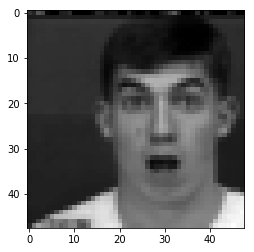

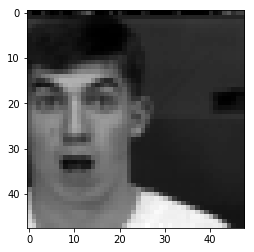

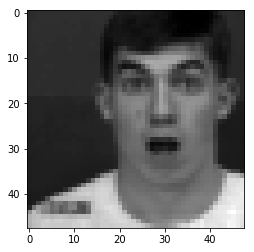

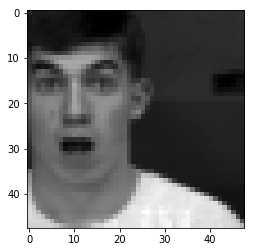

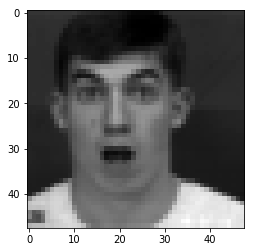

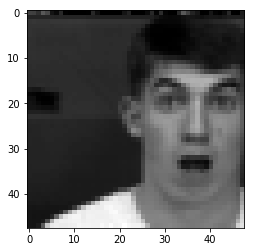

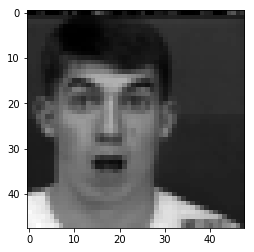

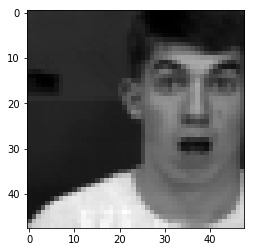

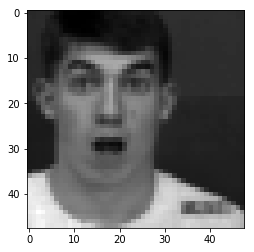

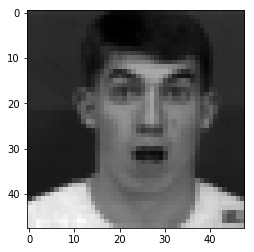

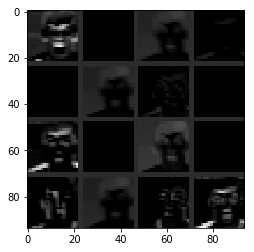

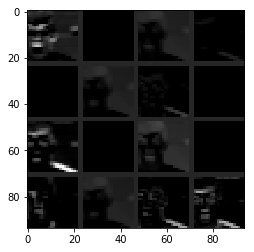

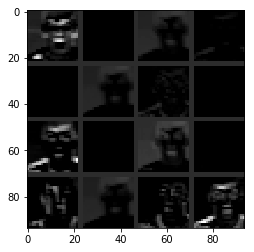

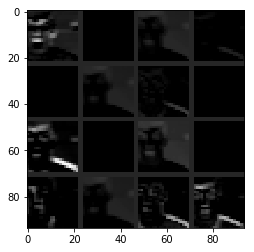

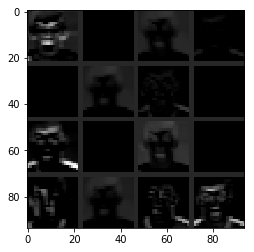

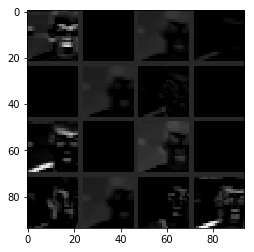

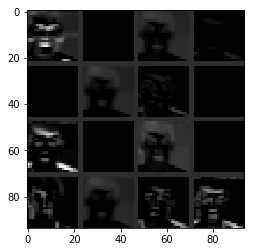

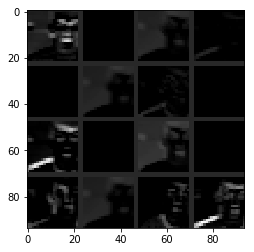

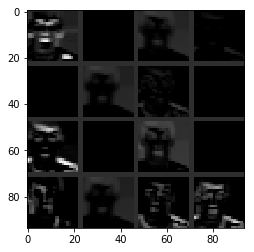

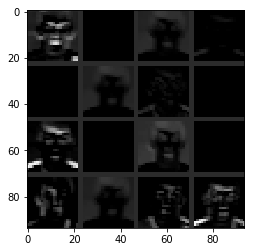

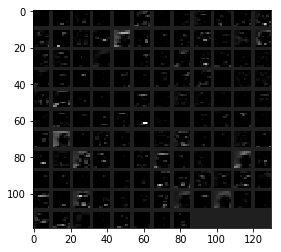

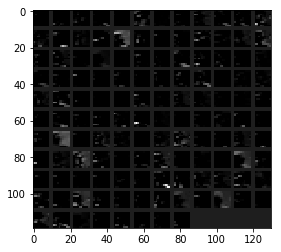

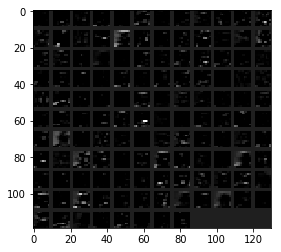

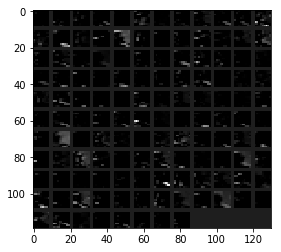

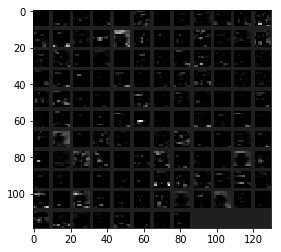

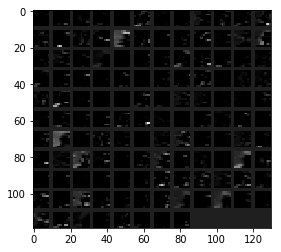

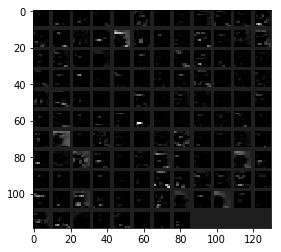

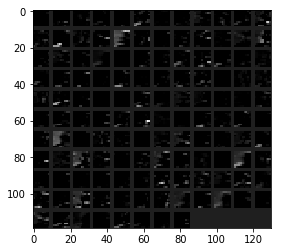

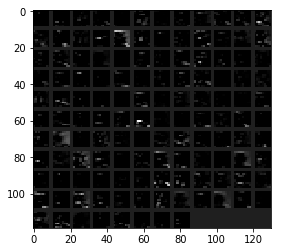

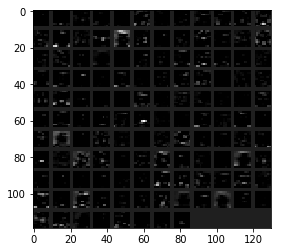

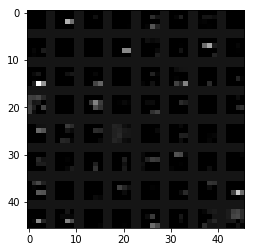

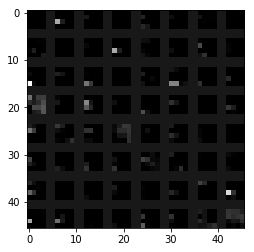

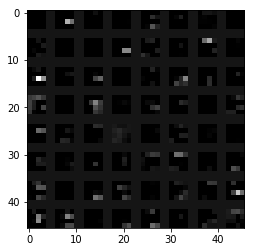

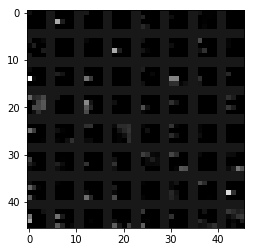

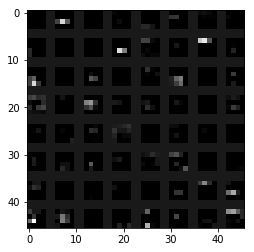

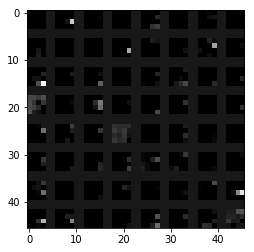

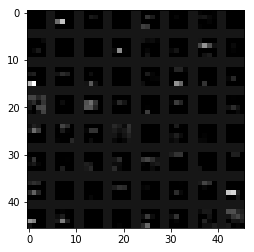

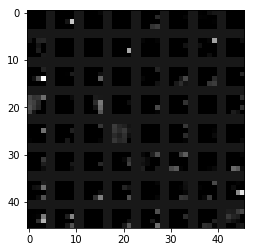

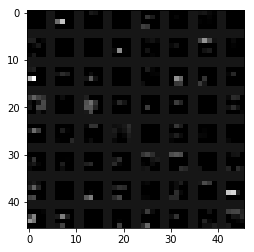

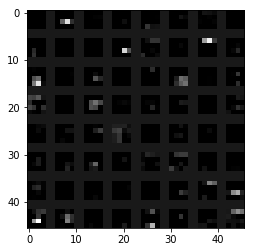

In [13]:
draw_features_of_net(net, 'test')